In [5]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys

import warnings

warnings.filterwarnings(action="ignore")
warnings.simplefilter(action="ignore")

# 定义要处理的模型(YOLOv8n目标检测模型)

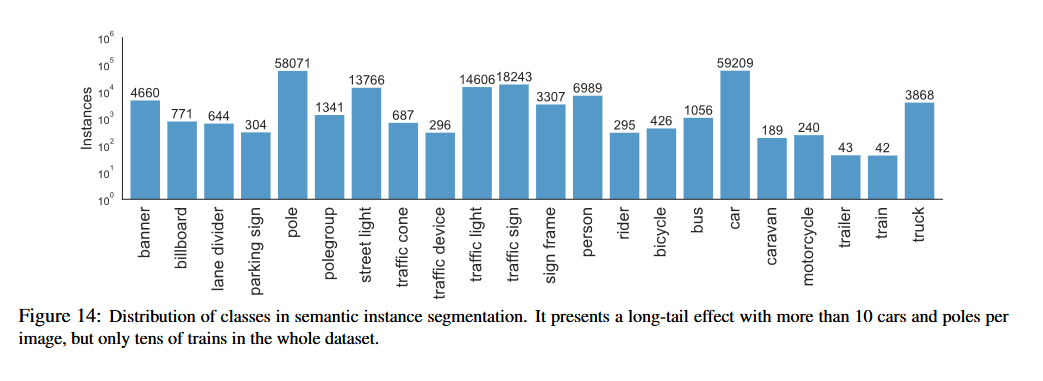

In [ ]:
yolo = YOLO(model='./models/yolo/best.pt')
yolo = yolo.cuda()
yolo.info(detailed=True)
print(yolo.names)
results = yolo(source="./images/origin_img_2.jpg")
for result in results:
    print(result[0].boxes.cls)
    # result.show()
results = yolo(source="./images/perturbed_img_2.jpg")
for result in results:
    print(result[0].boxes.cls)
    # result.show()

AttributeError: Can't get attribute 'DetectionModel' on <module 'models.yolo' from 'e:\\YoloCAM\\models\\yolo\\__init__.py'>

选择要处理的层

In [ ]:
yolo.info(detailed=True)
yolo_model = yolo.model
device = torch.device(device="cuda" if torch.cuda.is_available() else "cpu")
yolo_model = yolo_model.to(device).eval()
for param in yolo_model.parameters():
    param.requires_grad = False  # 冻结模型参数

layer                                    name                type  gradient  parameters               shape        mu     sigma
    0                     model.0.conv.weight              Conv2d     False        1296       [48, 3, 3, 3]   -0.0602       8.5        float32
    0                       model.0.conv.bias              Conv2d     False          48                [48]     0.688      2.38        float32
    1                             model.0.act                SiLU     False           0                  []         -         -              -
    2                     model.1.conv.weight              Conv2d     False       41472      [96, 48, 3, 3]  -0.00185    0.0721        float32
    2                       model.1.conv.bias              Conv2d     False          96                [96]      1.39      1.54        float32
    3                 model.2.cv1.conv.weight              Conv2d     False        9216      [96, 96, 1, 1]  -0.00937    0.0846        float32
    3         

选择要进行CAM操作的目标层,暂时只检查backbone

In [ ]:
yolo_nn = yolo_model.model
layer_map = {
    # 如果要选择其他c2f输出,只需要更改这个字典
    "backbone_c2f1": 2,
    "backbone_c2f2": 4,
    "backbone_c2f3": 6,
    "backbone_c2f4": 8, 
    "backbone_sppf": 9,
    "neck_c2f1": 12,
    "neck_c2f2": 15,
    "neck_c2f3": 18,
    "neck_c2f4": 21
}

layers = {layer: yolo_nn[idx] for layer, idx in layer_map.items()}

In [ ]:
# 加载YOLO模型（以v8为例）
neck_c2f3 = yolo_nn[layer_map['neck_c2f3']]
# print(neck_c2f3)
# 存储特征图的字典
features = {}
target_conv = []

# 定义钩子函数：保存当前层输出
def hook_fn(module, input, output, path) -> None:
    features[path] = output

# 遍历c2f中的所有子模块
def register_hooks(module, parent_path="") -> None:
    for name, child in module.named_children():
        current_path = f"{parent_path}.{name}" if parent_path else name
        if isinstance(child, torch.nn.Conv2d):
            child.register_forward_hook(hook=lambda m, i, o, path=current_path: hook_fn(module=m, input=i, output=o, path=path))
        else:
            register_hooks(module=child, parent_path=current_path)

print('layers in module:\'neck_c2f3\'')    
register_hooks(module=neck_c2f3, parent_path="neck_c2f3")

# 归一化每个通道到[0, 255]（灰度图）
def normalize(feature):
    feature = feature - feature.min()
    feature = feature / (feature.max() + 1e-8)
    return (feature * 255).byte().cpu().numpy()
     
# 输入测试数据触发前向传播
output = yolo(source='./images/perturbed_img_2.jpg')
# 提取特征图（features字典中保存了各卷积层的输出）
print('feature size in each layer')
for path, feature in features.items():
    print(f"{path}: {feature.shape}")
     # 选择batch维度的第一个元素
    feature = feature.squeeze(0)
    # 选择要可视化的通道（示例：前8个通道）
    num_vis = 8  # 可调整为其他数量（如16）
    selected_channels = feature[:num_vis]  # 或按响应值排序后选择

    # 可视化
    # fig, axes = plt.subplots(1, num_vis, figsize=(20, 5))
    # for i, (ax, channel) in enumerate(zip(axes, selected_channels)):
    #     # 归一化并转为二维图像
    #     img = normalize(channel)
    #     # 显示灰度图（或用cmap='viridis'显示伪彩色）
    #     ax.imshow(img, cmap='gray')
    #     ax.set_title(f'Channel {i+1}')
    #     ax.axis('off')
    # plt.tight_layout()
    # plt.show()

layers in module:'neck_c2f3'

image 1/1 e:\YoloCAM\images\perturbed_img_2.jpg: 640x640 2 DP.135s, 2 P.103bs, 28.1ms
Speed: 2.1ms preprocess, 28.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
feature size in each layer
neck_c2f3.cv1.conv: torch.Size([1, 384, 40, 40])
neck_c2f3.m.0.cv1.conv: torch.Size([1, 192, 40, 40])
neck_c2f3.m.0.cv2.conv: torch.Size([1, 192, 40, 40])
neck_c2f3.m.1.cv1.conv: torch.Size([1, 192, 40, 40])
neck_c2f3.m.1.cv2.conv: torch.Size([1, 192, 40, 40])
neck_c2f3.cv2.conv: torch.Size([1, 384, 40, 40])


In [ ]:
from functools import partial
import torchvision.transforms as T

class SaveFeatures:
    def __init__(self) -> None:
        self.features = {}
        self.hooks = []
    def hook_fn(self, module, input, output, path) -> None:
        self.features[path] = output
    def register_hooks(self, module, parent_path) -> None:
        for name, child in module.named_children():
            current_path = f"{parent_path}.{name}" if parent_path else name
            if isinstance(child, torch.nn.Conv2d):
                # 使用partial绑定self和path参数
                hook = child.register_forward_hook(
                    hook=partial(self.hook_fn, path=current_path)
                )
                self.hooks.append(hook)  # 保存钩子以便后续移除
            else:
                # 递归处理子模块
                self.register_hooks(module=child, parent_path=current_path)
    def get_features(self):
        return self.features
    def close(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()

class FilterVisualizer():
    def __init__(self, model, module, target_layer_path, parent_path, size=56, upscaling_steps=12, upscaling_factor=1.2):
        self.model, self.module, self.target_layer_path, self.parent_path = model, module, target_layer_path, parent_path
        self.size, self.upscaling_steps, self.upscaling_factor = size, upscaling_steps, upscaling_factor
        
    def get_yolo_transforms(self, sz: int):
        val_tfms = T.Compose(transforms=[
            T.ToTensor(),
            T.Resize(size=(sz, sz)),
        ])
        train_tfms = val_tfms
        return train_tfms, val_tfms
    
    def denorm(self, tensor: torch.Tensor) -> np.ndarray:
        """反归一化：将 [0,1] 张量恢复为 [0,255] 图像（HWC）"""
        img = tensor.permute(1, 2, 0).cpu().numpy() * 255
        return np.clip(img, 0, 255).astype(np.uint8)
    
    # def visualize(self, layer, filter, lr=0.1, opt_steps=20, blur=None):
    def visualize(self, filter_idx, lr=0.1, opt_steps=20, blur=None, cmd=False) -> None:   
        self.model.model.train()   
        loss = 0
        sz = self.size  
        img = np.float32(np.random.uniform(low=150, high=180, size=(sz, sz, 3))/255)
        save_features = SaveFeatures()
        save_features.register_hooks(module=self.module, parent_path=self.parent_path)
        
        train_tfms, val_tfms = self.get_yolo_transforms(sz=sz)
        img_tensor = val_tfms(img=img).unsqueeze(0)  # type: ignore # [1, 3, sz, sz]
        img_var = torch.tensor(data=img_tensor, requires_grad=True, device=self.model.device, dtype=torch.float32)
        for step in range(self.upscaling_steps):
            # print(f"upscaling step{step+1}")
            # 步骤3：初始化优化器（优化图像像素值）
            optimizer = torch.optim.Adam(params=[img_var], lr=lr, weight_decay=1e-6)
            # 步骤4：优化像素值（最大化目标 filter 的激活）
            for n in range(opt_steps):
                optimizer.zero_grad()
                _ = self.model.model(img_var)  # YOLOv8 前向传播（输出可能包含多个特征图，但钩子仅捕获目标层）
                activations = save_features.get_features()
                target_features = activations[self.target_layer_path]
                if target_features is None:
                    raise ValueError(f"未找到目标层特征，路径：{self.target_layer_path}")
                loss = -target_features[0, filter_idx].mean()  # [0, filter_idx] 对应 batch 0，第 filter_idx 个通道
                loss.backward()
                optimizer.step()
            if cmd:
                print(f"loss in epoch{step+1}: {loss}")
            # 步骤5：反归一化并恢复图像（HWC, [0,255]）
            img = self.denorm(img_var.detach().squeeze(0))  # [3, sz, sz] → [sz, sz, 3]
            # print(img)
            self.output = img
            # 步骤6：上采样图像（为下一轮优化准备更大尺寸）
            sz = int(self.upscaling_factor * sz)
            img = cv2.resize(img, (sz, sz), interpolation=cv2.INTER_CUBIC)  # 上采样
            if blur is not None:
                img = cv2.blur(img, (blur, blur))  # 模糊去高频噪声
            # plt.imshow(X=np.clip(a=self.output, a_min=0, a_max=1))
        # 清理钩子（避免内存泄漏）
        self.model.model.eval()
        save_features.close()
        # 保存结果
        file_name = "./filter/"+str(object=self.target_layer_path)+"_filter_"+str(object=filter_idx+1)+".jpg"
        print(f"save: {file_name}")
        plt.imsave(fname="./filter/layer_"+str(object=self.target_layer_path)+"_filter_"+str(object=filter_idx+1)+".jpg", arr=self.output)
        if cmd:  
            plt.imshow(X=self.output)

In [ ]:
FV = FilterVisualizer(
	model=yolo,
 	module=neck_c2f3,
	target_layer_path='neck_c2f3.cv1.conv',
	parent_path='neck_c2f3',
	size=480,
	upscaling_steps=20,
    upscaling_factor=1.2
)

In [ ]:
FV.visualize(filter_idx=20, lr=0.002, opt_steps=20, blur=5, cmd=False)

save: ./filter/neck_c2f3.cv1.conv_filter_21.jpg


In [ ]:
filter_num = 384
for filter_idx in range(0, filter_num):
	FV.visualize(filter_idx=filter_idx, lr=0.002, opt_steps=20, blur=5, cmd=False)

save: ./filter/backbone_c2f3.cv1.conv_filter_1.jpg
save: ./filter/backbone_c2f3.cv1.conv_filter_2.jpg
save: ./filter/backbone_c2f3.cv1.conv_filter_3.jpg
save: ./filter/backbone_c2f3.cv1.conv_filter_4.jpg


In [ ]:
# C2f(
#   (cv1): Conv(
#     (conv): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
#     (act): SiLU(inplace=True)
#   )
#   (cv2): Conv(
#     (conv): Conv2d(1152, 384, kernel_size=(1, 1), stride=(1, 1))
#     (act): SiLU(inplace=True)
#   )
#   (m): ModuleList(
#     (0-3): 4 x Bottleneck(
#       (cv1): Conv(
#         (conv): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#         (act): SiLU(inplace=True)
#       )
#       (cv2): Conv(
#         (conv): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#         (act): SiLU(inplace=True)
#       )
#     )
#   )
# )

backbone_c2f3 = yolo_nn[layer_map['backbone_c2f3']]
print(backbone_c2f3)

FV = FilterVisualizer(
	model=yolo,
 	module=backbone_c2f3,
	target_layer_path='backbone_c2f3.cv1.conv',
	parent_path='backbone_c2f3',
	size=320,
	upscaling_steps=20,
    upscaling_factor=1.2
)

filter_num = 384	# **
for filter_idx in range(0, filter_num):
	FV.visualize(filter_idx=filter_idx, lr=0.002, opt_steps=20, blur=5, cmd=False)

C2f(
  (cv1): Conv(
    (conv): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(1152, 384, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (m): ModuleList(
    (0-3): 4 x Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
    )
  )
)
save: ./filter/backbone_c2f3.cv1.conv_filter_1.jpg
save: ./filter/backbone_c2f3.cv1.conv_filter_2.jpg
save: ./filter/backbone_c2f3.cv1.conv_filter_3.jpg
save: ./filter/backbone_c2f3.cv1.conv_filter_4.jpg
save: ./filter/backbone_c2f3.cv1.conv_filter_5.jpg
save: ./filter/backbone_c2f3.cv1.conv_filter_6.jpg
save: ./filter/backbone_c2f3.cv1.conv_filter_7.jpg
save: ./filter/backbone_c2f3.cv1.conv_filter_8.jpg
save: ./filt

: 